In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set(style='ticks')
color = sns.color_palette()

import thinkstats2, thinkplot # Do "pip install thinkx", if necessary

%matplotlib inline

In [2]:
train_df = pd.read_json("train.json")

## data description

In [3]:
train_df.iloc[2][['bathrooms', 'bedrooms', 'listing_id', 'building_id', 'manager_id',
                  'created', 'latitude', 'longitude', 'price', 'display_address', 'street_address',
                  'description', 'features', 'photos', 'interest_level']]

bathrooms                                                          1
bedrooms                                                           1
listing_id                                                   6887163
building_id                         c3ba40552e2120b0acfc3cb5730bb2aa
manager_id                          d9039c43983f6e564b1482b273bd7b01
created                                          2016-04-17 03:26:41
latitude                                                     40.7388
longitude                                                   -74.0018
price                                                           2850
display_address                                          W 13 Street
street_address                                       241 W 13 Street
description        Top Top West Village location, beautiful Pre-w...
features           [Laundry In Building, Dishwasher, Hardwood Flo...
photos             [https://photos.renthop.com/2/6887163_de85c427...
interest_level                    

- bathrooms: number of bathrooms
- bedrooms: number of bathrooms
- listing_id: 포스팅 ID
- building_id: 건물 ID
- manager_id: 포스팅 게시자 ID
- created: 포스팅 된 시각 (UTC 기준으로 생각됨)
- latitude: 위도
- longitude: 경도
- price: in USD

- display_address: 주소 (도로명까지)
- street_address: 주소 (번지까지)

In [4]:
train_df.iloc[2][['display_address', 'street_address']]

display_address        W 13 Street
street_address     241 W 13 Street
Name: 100004, dtype: object

- description: 게시자의 소개글
- features: a list of features about this apartment

In [5]:
train_df.iloc[2]['description']

u'Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and conveniently located near A,C,E,L,1,2,3 trains. Surrounded by many local cafe?s, restaurants, available for November 1st move in!<br/><br/>To view this apartment or any other please contact me via email or call at the number listed.<br/><br/><br/><br/><br/><br/>Bond New York is a real estate broker that supports equal housing opportunity.<p><a  website_redacted '

In [6]:
train_df.iloc[2]['features']

[u'Laundry In Building',
 u'Dishwasher',
 u'Hardwood Floors',
 u'Pets Allowed Case by Case']

- photos: a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 

In [7]:
train_df.iloc[2]['photos']

[u'https://photos.renthop.com/2/6887163_de85c427363a2e6d736a5df96d8d5541.jpg',
 u'https://photos.renthop.com/2/6887163_b9cf6db6df611bc53f75be3214a43807.jpg',
 u'https://photos.renthop.com/2/6887163_cd3f2246cfd25691f33ed12b251d0230.jpg',
 u'https://photos.renthop.com/2/6887163_54c402cf0d681f6ea4796b9d177786bb.jpg',
 u'https://photos.renthop.com/2/6887163_7745da2a3693fe627154794ab0ebca29.jpg',
 u'https://photos.renthop.com/2/6887163_95c93e4af27182f8ac55c749fc74a041.jpg',
 u'https://photos.renthop.com/2/6887163_4b50a743b760e23b8d6f6f586a704da7.jpg',
 u'https://photos.renthop.com/2/6887163_6133523d6d5a0fba36bb25e3616848c8.jpg']

- interest_level: this is the target variable. It has 3 categories: 'high', 'medium', 'low'

In [8]:
train_df['interest_level'].head().tolist()

[u'medium', u'low', u'high', u'low', u'low']

## interest level (target variable)

/home/liam/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


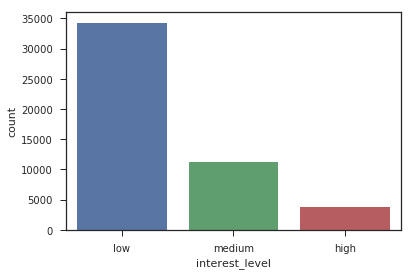

In [9]:
sns.countplot(x='interest_level', data=train_df, order=['low', 'medium', 'high'])
plt.show()

interest_level은 대부분 low이고, high는 가장 적다.

모델 학습할 때 클래스 간의 비율을 1:1:1로 맞추기 위해 oversampling/undersampling 필요.

## price

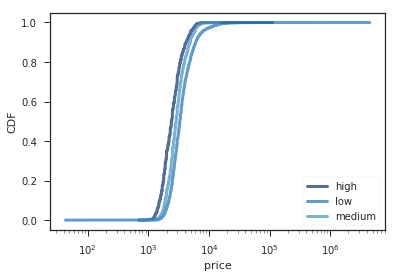

In [10]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['price'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='price', ylabel='CDF', xscale='log')

가격이 저렴할 수록 interest level이 높다.

## bathrooms

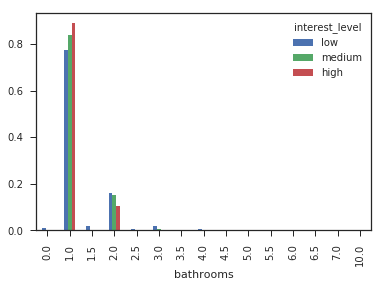

In [11]:
bathrooms = train_df.groupby(['bathrooms', 'interest_level'])['bathrooms'].count().unstack('interest_level')
bathrooms /= bathrooms.sum()
bathrooms[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

화장실은 대체로 1개이고, 침실은 0-2개인 경우가 많다.

화장실이 1개일 때 상대적으로 high일 가능성이 크고, 화장실이 2개일 때는 high일 가능성이 적다. 나머지 경우 low일 가능성이 크다.

## bedrooms

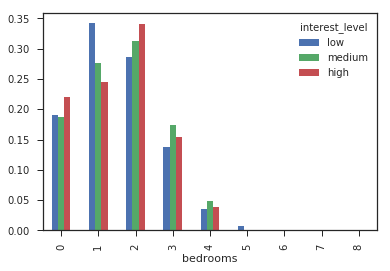

In [12]:
bedrooms = train_df.groupby(['bedrooms', 'interest_level'])['bedrooms'].count().unstack('interest_level')
bedrooms /= bedrooms.sum()
bedrooms[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 침실이 0, 2개일 때 high일 가능성이 크다.
- 침실이 1개일 때, 그리고 5개 이상일 때 low일 가능성이 크다.
- 침실이 3, 4개일 때 medium일 가능성이 크다.

## created

In [13]:
train_df['created'] = pd.to_datetime(train_df['created'])
train_df['week'] = train_df['created'].dt.week
# train_df['hour'] = train_df['created'].dt.hour
train_df['hour'] = (train_df['created'].dt.hour - 5) % 24 # 동부 표준시는 UTC-05:00 이다.
train_df['weekday'] = train_df['created'].dt.weekday

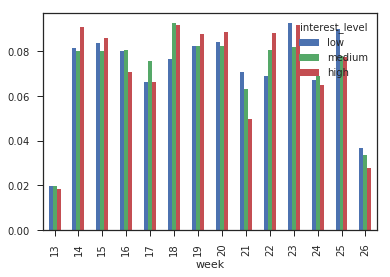

In [14]:
weeks = train_df.groupby(['week', 'interest_level'])['week'].count().unstack('interest_level')
weeks /= weeks.sum()
weeks[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

주별로 차이가 있지만 그 차이가 미미하다.

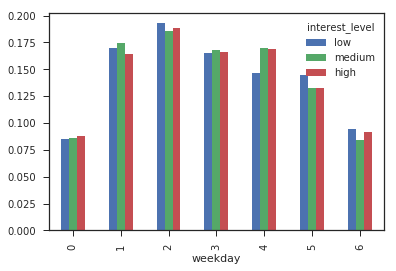

In [15]:
weekdays = train_df.groupby(['weekday', 'interest_level'])['weekday'].count().unstack('interest_level')
weekdays /= weekdays.sum()
weekdays[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

weekday가 0이면 월요일, 1이면 화요일, ..., 6이면 일요일이다.

요일에 대한 분포에는 약간의 차이는 있지만 미미하다.

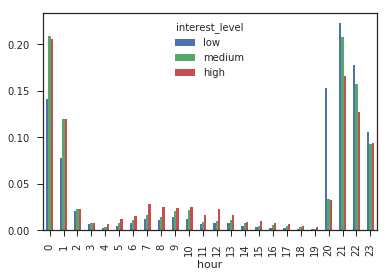

In [16]:
hours = train_df.groupby(['hour', 'interest_level'])['hour'].count().unstack('interest_level').fillna(0)
hours /= hours.sum()
hours[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

시간에 대한 분포에 차이가 있음. 20-23시, 특히 20시에 게시된 글은 low일 가능성이 높다. 낮에 게시된 글은 high일 가능성이 높다.

## photos, features & descriptions

In [17]:
train_df.loc[:, 'num_photos'] = train_df.loc[:, 'photos'].apply(len)
train_df.loc[:, 'num_features'] = train_df.loc[:, 'features'].apply(len)
train_df.loc[:, 'num_words'] = train_df.loc[:, 'description'].apply(lambda x: len(x.split(' ')))

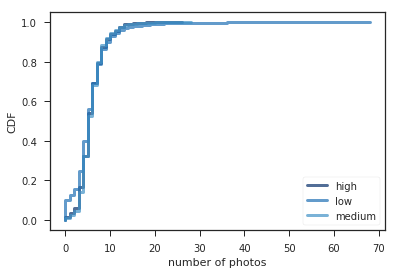

In [18]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_photos'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of photos', ylabel='CDF')

세 분포가 사진이 10개 이하일 때 차이가 있다.

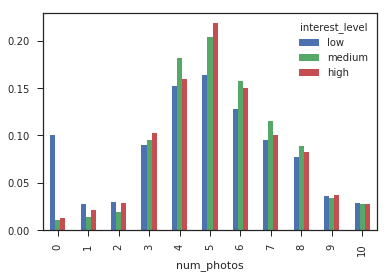

In [19]:
photos = train_df.groupby(['num_photos', 'interest_level'])['num_photos'].count().unstack('interest_level').fillna(0)
photos /= photos.sum()
photos.ix[:10, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

사진이 0개이면 low일 가능성이 아주 크고, 4-8개이면 low일 가능성이 적다. 특히, 5개일 때 high일 가능성이 아주 높다.

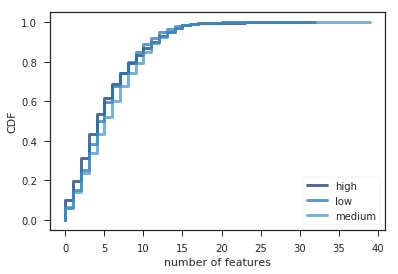

In [20]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_features'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of features', ylabel='CDF')

세 분포가 특징이 15개 이하일 때 차이가 있다.

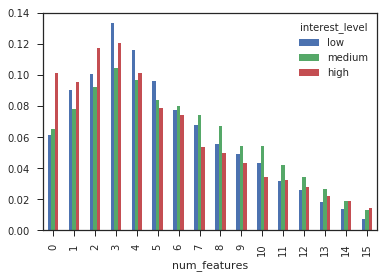

In [21]:
features = train_df.groupby(['num_features', 'interest_level'])['num_features'].count().unstack('interest_level').fillna(0)
features /= features.sum()
features.ix[:15, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 대체로 특징이 적을 때, 0-2개일 때 high일 가능성이 크다.
- 특징이 3-5개일 때 low일 가능성이 크다.
- 특징이 6개 이상이면 medium일 가능성이 크다.

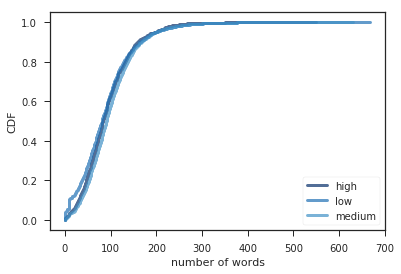

In [22]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_words'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of words', ylabel='CDF')

세 분포가 거의 일치. 개수가 아주 적을 때 약간의 차이가 있다.

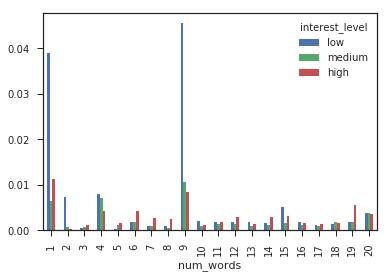

In [23]:
words = train_df.groupby(['num_words', 'interest_level'])['num_words'].count().unstack('interest_level').fillna(0)
words /= words.sum()
words.ix[:20, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

개수가 1, 9개일 때 low일 가능성이 아주 크나, 그외의 경우 차이가 미미하다.